In [2]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

from scipy.stats import ortho_group

# from sklearn.decomposition import PCA

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
N = 350
P = 15000

In [1]:
def plot_with_gaussian(Q, ax, label):
    
    muQ = np.mean(Q)
    sigmaQ = np.std(Q)
    
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax.hist(Q, bins = bins, density = True, alpha = 0.3, label = "Empirical")
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'Analytical')
    ax.set_title(label)
    ax.set_xlabel("Q-score")
    ax.legend()
    
    return

def getQ(X, Y, Ysep, ax1, ax2):
    niter = 2000
    N = X.shape[0]
    
    _, S, Vt = np.linalg.svd(Y, full_matrices=False)    
    U = ortho_group.rvs(dim = N)
    #_, Snew, _ = np.linalg.svd(Ysep, full_matrices=False)
    Snew = np.square(np.sort(np.random.normal(loc = np.mean(S), scale = np.std(S), size = N))[::-1])
    # Snew = np.random.normal(500, 10, size = S.shape[0]) + np.random.normal(10, 20, size = S.shape[0])
    
    fact = np.median(Snew)
    print("fact:", fact)
    
    nComp = 2
    S1 = Snew / (Snew + fact)
    
    S2 = Snew.copy()
    if nComp > 0:
        S2[:nComp] = 1e-10
    S2 = S2 / (S2 + fact)
    #print(S3)
    print("Keff S1:", np.sum(S1))
    print("Keff S2:", np.sum(S2))
    
    Q1 = np.zeros(niter)
    Q2 = np.zeros(niter)
    
    for i in range(niter):
        # np.random.shuffle(X)
        X = permuted_dosage(nsample = N, maf = 0.3)
        X = X - np.mean(X)
        X = X / np.linalg.norm(X)
        for j in range(N):
            utx = np.dot(U[:, j], X)
            #utx_pca = np.dot(U_pca[:, j], X)
            Q1[i] += np.square(utx) * S1[j]
            Q2[i] += np.square(utx) * S2[j]
            
    plot_with_gaussian(Q1, ax1, 'Normal Expression')
    plot_with_gaussian(Q2, ax2, 'Corrected Expression')
    
    return S1, S2, Q1, Q2

def permuted_dosage(nsample = 350, maf = 0.1):
    i = 0
    f = [maf]
    dosage = np.zeros((nsample))
    snpinfo = list()
    mafratios = np.array([(1 - f[i])**2, 2 * f[i] * (1 - f[i]), f[i]**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    gtcent = dosage - np.mean(dosage)
    return gtcent

def center_and_scale(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

In [4]:
# X = getX(N)
# X = np.random.normal(loc = 0, scale = 1, size = N)
X = permuted_dosage(nsample = N, maf = 0.3)
X = X - np.mean(X)

Y = np.random.normal(loc = 0, scale = 1, size = N * P).reshape(N, P)
Ysep = np.random.normal(loc = 0, scale = 1, size = N * P).reshape(N, P)

Y = center_and_scale(Y) / np.sqrt(N)
Ysep = center_and_scale(Ysep) / np.sqrt(N)

fact: 42.72303360739139
Keff S1: 174.5589966503183
Keff S2: 173.3670751821827


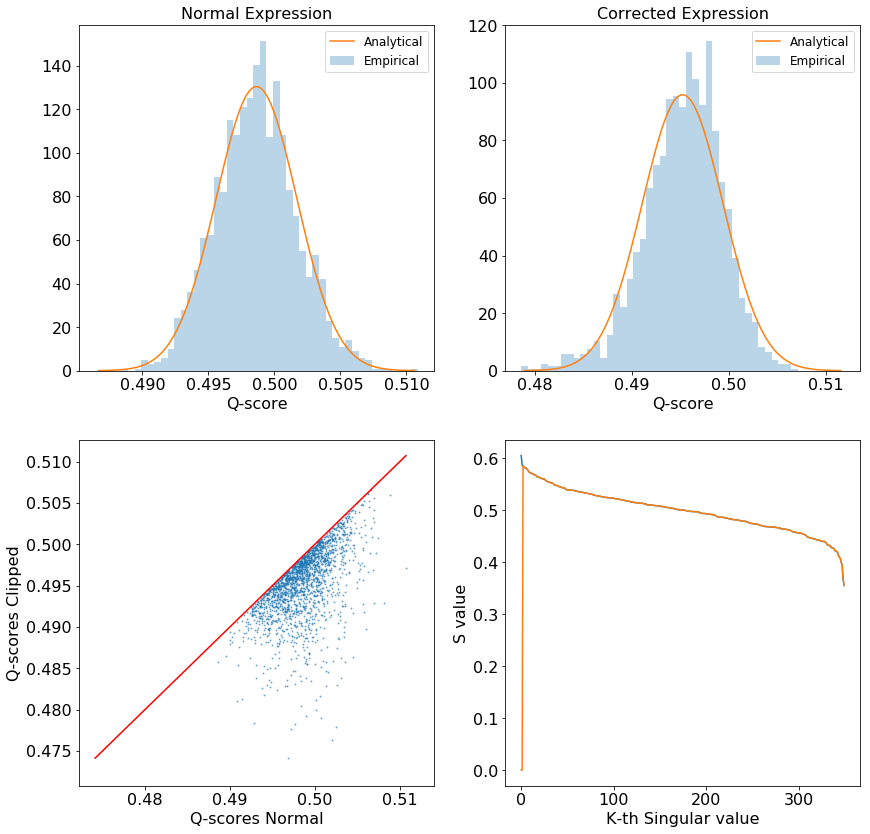

In [5]:
fig = plt.figure(figsize = (14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

S1, S2, Q1, Q2 = getQ(X, Y, Ysep, ax1, ax2)

ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax3.scatter(Q1, Q2, s = 1, alpha = 0.5)
Qmin = min(np.min(Q1), np.min(Q2))
Qmax = max(np.max(Q1), np.max(Q2))
ax3.plot([Qmin, Qmax], [Qmin, Qmax], color = 'red')
ax3.set_xlabel("Q-scores Normal")
ax3.set_ylabel("Q-scores Clipped")
ax4.plot(np.arange(N), S1)
ax4.plot(np.arange(N), S2)
ax4.set_xlabel("K-th Singular value")
ax4.set_ylabel("S value")
plt.show()


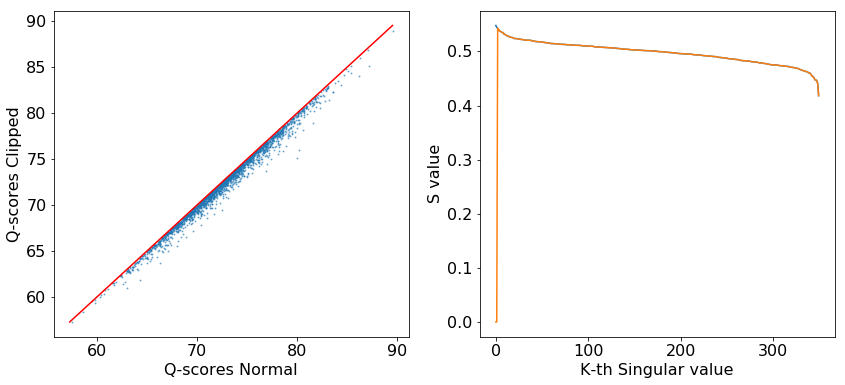

In [63]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(Q1, Q2, s = 1, alpha = 0.5)
Qmin = min(np.min(Q1), np.min(Q2))
Qmax = max(np.max(Q1), np.max(Q2))
ax1.plot([Qmin, Qmax], [Qmin, Qmax], color = 'red')
ax1.set_xlabel("Q-scores Normal")
ax1.set_ylabel("Q-scores Clipped")
ax2.plot(np.arange(N), S1)
ax2.plot(np.arange(N), S2)
ax2.set_xlabel("K-th Singular value")
ax2.set_ylabel("S value")
plt.show()

In [ ]:
def getQncomp(X, Y, Ysep, ax1, ax2, nComp):
    niter = 2000
    N = X.shape[0]
    
    _, S, Vt = np.linalg.svd(Y, full_matrices=False)    
    U = ortho_group.rvs(dim = N)
    _, Snew, _ = np.linalg.svd(Ysep, full_matrices=False)
    # Snew = np.sort(np.random.normal(loc = np.mean(S), scale = np.std(S), size = N))
    # Snew = np.random.normal(500, 10, size = S.shape[0]) + np.random.normal(10, 20, size = S.shape[0])
    
    fact = np.median(Snew)
    print("fact:", fact)
    
    S1 = Snew / (Snew + fact)
    
    S2 = Snew.copy()
    S2[:nComp] = 1e-10
    S2 = S2 / (S2 + fact)
    #print(S3)
    print("Keff S1:", np.sum(S1))
    print("Keff S2:", np.sum(S2))
    
    Q1 = np.zeros(niter)
    Q2 = np.zeros(niter)
    
    for i in range(niter):
        np.random.shuffle(X)
        # X = permuted_dosage(nsample = N, maf = 0.3)
        for j in range(N):
            utx = np.dot(U[:, j], X)
            #utx_pca = np.dot(U_pca[:, j], X)
            Q1[i] += np.square(utx) * S1[j]
            Q2[i] += np.square(utx) * S2[j]
            
    plot_with_gaussian(Q1, ax1, "A")
    plot_with_gaussian(Q2, ax2, "B")
    ax1.set_title("Full")
    ax2.set_title('Clipped - {:d} Ncomp'.format(nComp))
    
    return S1, S2, Q1, Q2

ncomp = 6
fig = plt.figure(figsize = (14,6*ncomp/2))
nrow = ncomp / 2
ncol = 2
j=0
for i in range(0,ncomp,2):
    print(i)
    ax1 = fig.add_subplot(nrow,ncol,j+1)
    ax2 = fig.add_subplot(nrow,ncol,j+2)
    S1, S2, Q1, Q2 = getQncomp(X, Y, Ysep, ax1, ax2, i)
    j += 2

plt.show()

In [ ]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(Q1, Q2, s = 1, alpha = 0.5)
ax2.scatter(S1[2:], S2[2:], s = 1, alpha = 0.5)
plt.show()